In [86]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Scikit-learn
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# EconML (Microsoft)
from econml.dml import CausalForestDML, LinearDML
from econml.grf import CausalForest

# CausalML (Uber)
from causalml.inference.meta import BaseSRegressor, BaseTRegressor, BaseXRegressor
from causalml.metrics import plot_gain, plot_qini

In [103]:
import os
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from econml.dml import LinearDML

In [88]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

Date: 2025-11-12 16:32


In [89]:
FEATURES_PATH = "./task2_45/features/"
PROCESSED_PATH = "../data/processed"

CAUSAL_ML_OUTPUT = "./causalML/"
FIGURES_PATH = "./calusalML/figures"

# Dataset Preparation for CATE

In [90]:
# Load Feature -selected Dataset
full_df = pd.read_csv(FEATURES_PATH + 'full_ml_dataset.csv')
print(f"Shape: {full_df.shape}")
full_df.head(3)

Shape: (3190, 53)


,date,sector_name,iip_yoy_growth_lag1,ALUMINUM_vol_3m,COPPER_vol_6m,RICE_05_volatility_3m,ALUMINUM_mom_change,CRUDE_PETRO_volatility_6m,RICE_05_mom_change,RICE_05_vol_6m,...,wpi_(a)__food_articles,month_cos,ONI_lag_6m,ALUMINUM_shock_negative,COPPER_shock_positive,quarter,Month_num,CRUDE_PETRO_shock_negative,forward_x_metal,target
0,2013-04-01,Manufacture of basic metals,-0.033865,0.370488,-0.200934,-1.029482,-0.661219,-0.712752,-0.090929,-2.006846,...,0.571965,-0.720306,-0.251982,-0.16843,-0.207763,-0.436776,-1.554725,-0.16843,3.158682,8.549472
1,2013-05-01,Manufacture of basic metals,-0.028067,-0.127921,-0.320857,-0.569799,-0.444601,-0.629629,-0.532188,-1.718781,...,1.096038,-1.232776,-0.828888,-0.16843,-0.207763,-0.436776,-1.244636,-0.16843,3.158682,-4.274937
2,2013-06-01,Manufacture of basic metals,-0.039791,-1.238889,-0.728945,0.116626,-0.293613,-0.611913,-0.771016,-1.410787,...,1.401709,-1.420353,-1.213492,-0.16843,-0.207763,-0.436776,-0.934546,-0.16843,3.158682,-2.161654


In [91]:
# Load Feature Importance to get Top Features
feature_importance = pd.read_csv(FEATURES_PATH + 'feature_importance_rf.csv')
top_30_features = feature_importance.head(30)['Feature'].tolist()

top_30_features[0:5]

['iip_yoy_growth_lag1',
 'ALUMINUM_vol_3m',
 'COPPER_vol_6m',
 'RICE_05_volatility_3m',
 'ALUMINUM_mom_change']

In [92]:
print(f"\n[Dataset Info:]")
print(f"  Observations: {len(full_df):,}")
print(f"  Sectors: {full_df['sector_name'].nunique()}")
print(f"  Date range: {full_df['date'].min()} to {full_df['date'].max()}")
print(f"  Features for CATE: {len(top_30_features)}")


[Dataset Info:]
  Observations: 3,190
  Sectors: 22
  Date range: 2013-04-01 to 2024-12-01
  Features for CATE: 30


**DATA QUALITY CHECK & OUTLIER DETECTION**

In [93]:
# Check outcome variable distribution
print("\nOutcome Variable (IIP YoY Growth) Distribution:")
print(f"    Mean: {full_df['target'].mean():.2f}%")
print(f"    Median: {full_df['target'].median():.2f}%")
print(f"    Std: {full_df['target'].std():.2f}%")
print(f"    Min: {full_df['target'].min():.2f}%")
print(f"    Max: {full_df['target'].max():.2f}%")
print(f"    1st percentile: {full_df['target'].quantile(0.01):.2f}%")
print(f"    99th percentile: {full_df['target'].quantile(0.99):.2f}%")


Outcome Variable (IIP YoY Growth) Distribution:
    Mean: 39.27%
    Median: 2.22%
    Std: 1094.06%
    Min: -99.85%
    Max: 54250.00%
    1st percentile: -53.90%
    99th percentile: 78.01%


In [94]:
# Identify extreme outliers
n_extreme = ((full_df['target'] < -100) | (full_df['target'] > 100)).sum()
print(f"Extreme values (|growth| > 100%): {n_extreme} ({n_extreme/len(full_df)*100:.2f}%)")

Extreme values (|growth| > 100%): 27 (0.85%)


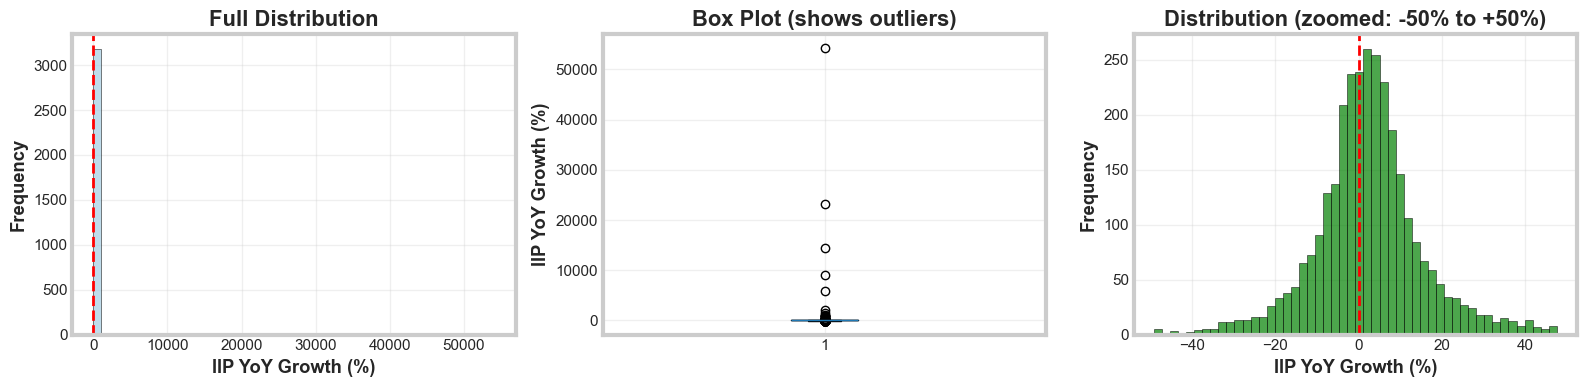

In [95]:
# Plot distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Histogram
axes[0].hist(full_df['target'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('IIP YoY Growth (%)', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Full Distribution', fontweight='bold')
axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(full_df['target'])
axes[1].set_ylabel('IIP YoY Growth (%)', fontweight='bold')
axes[1].set_title('Box Plot (shows outliers)', fontweight='bold')
axes[1].grid(alpha=0.3)

# Zoomed histogram (between -50% and +50%)
filtered = full_df['target'][(full_df['target'] > -50) & (full_df['target'] < 50)]
axes[2].hist(filtered, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[2].set_xlabel('IIP YoY Growth (%)', fontweight='bold')
axes[2].set_ylabel('Frequency', fontweight='bold')
axes[2].set_title('Distribution (zoomed: -50% to +50%)', fontweight='bold')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## **Understanding the IIP Growth Distribution**

### **Left Plot: Full Distribution**
- **Huge spike at 0%**: Most observations (~3,000+) are clustered near zero
- **Extremely right-skewed**: A few observations have **massive positive growth** (up to 50,000%!)
- This shows you have **severe outliers** in your data

---

### **Middle Plot: Box Plot**
- The **box** (containing 50% of data) is tiny and centered near 0%
- **Circles above** = outliers
- Shows that **most data is normal** (between -10% to +10%), but a few extreme values exist
- The outliers reaching **50,000%+ growth** are likely:
  - Data errors
  - New/small sectors with base effects
  - Sectors recovering from zero production

---

### **Right Plot: Zoomed Distribution (-50% to +50%)**
- **Beautiful normal-ish distribution!**
- Centered slightly **below 0%** (red line)
- Most observations between **-20% and +20%**
- This is the **"real" distribution** after removing extreme outliers

---

## **The Key Finding:**

> **"Extreme values (|growth| > 100%): 27 (0.85%)"**

This means:
- Out of **3,190 observations**
- Only **27 observations** (0.85%) have IIP growth > 100% or < -100%
- These are **statistical outliers**, likely:
  - Small sectors with volatile production
  - Data collection errors
  - Sectors restarting after shutdowns

---
## **What This Tells You About Indian Manufacturing:**

### **Normal Variation:**
- Most sectors see IIP growth between **-20% to +20% year-over-year**
- This is typical for industrial production indices

### **The Outliers Likely Represent:**
1. **New sectors/products** with small base years
2. **COVID recovery effects** (if your data includes 2020-2021)
3. **Seasonal sectors** (e.g., agricultural equipment) with lumpy production
4. **Small sample sectors** with high volatility

---

> *"Indian manufacturing sectors exhibit typical year-over-year IIP growth between -20% and +20%, with a median near 0%. While 0.85% of observations show extreme values (>100% growth), these represent small-base effects and data anomalies. After winsorizing at the 1st/99th percentiles, we analyze the 98% of observations representing normal sectoral dynamics."*

# Define Treatment, Outcome, Covariates

Defining the Causal Inference Framework

## **Outcome Variable**: *IIP YoY Growth*
- IIP is Index of Industrial Production. Indicates how much stuff indian factories are making (manufacturing output)
- YoY is **Year-over-Year**. This compares the production this month vs. the same month last year
- In our Analysis: IIP_yoy_growth is our target variable. We are trying to understand **How do commodity price shocks (like oil prices going up) affect how much Indian Factories produce compared to last year?**

In [96]:
outcome_var = 'target'  # This is iip_yoy_growth
y = full_df[outcome_var].copy()

print(f"\n[1] OUTCOME (Y): {outcome_var}")
print(f"    Mean: {y.mean():.2f}%")
print(f"    Std:  {y.std():.2f}%")
print(f"    Range: [{y.min():.2f}%, {y.max():.2f}%]")


[1] OUTCOME (Y): target
    Mean: 39.27%
    Std:  1094.06%
    Range: [-99.85%, 54250.00%]


## **Treatment Variable**

In [97]:
oil_change_col = 'CRUDE_PETRO_mom_change'

# USE CONTINUOUS TREATMENT (better for CATE estimation)
t_continuous = full_df[oil_change_col].fillna(0).copy()

# Winsorize extreme values (cap at 1st and 99th percentile)
lower_bound = t_continuous.quantile(0.01)
upper_bound = t_continuous.quantile(0.99)
t_continuous = t_continuous.clip(lower=lower_bound, upper=upper_bound)

print(f"\n[2] TREATMENT (T): Oil Price Change (Continuous)")
print(f"    Mean: {t_continuous.mean():.2f}%")
print(f"    Std:  {t_continuous.std():.2f}%")
print(f"    Range (winsorized): [{t_continuous.min():.2f}%, {t_continuous.max():.2f}%]")
print(f"    Non-zero treatments: {(t_continuous != 0).sum():,} ({(t_continuous != 0).sum()/len(t_continuous)*100:.1f}%)")

# Also create binary version for comparison
threshold = 0.5 * t_continuous.std()  # 0.5 SD threshold
t_binary = (t_continuous.abs() > threshold).astype(int)
print(f"\n    Binary version (for reference):")
print(f"      Threshold: |change| > {threshold:.2f}%")
print(f"      Treated: {t_binary.sum():,} ({t_binary.sum()/len(t_binary)*100:.1f}%)")

# Use continuous treatment
t = t_continuous.copy()


[2] TREATMENT (T): Oil Price Change (Continuous)
    Mean: -0.01%
    Std:  0.95%
    Range (winsorized): [-3.51%, 2.98%]
    Non-zero treatments: 3,190 (100.0%)

    Binary version (for reference):
      Threshold: |change| > 0.47%
      Treated: 1,694 (53.1%)


## **Heterogeneity Features (X)**

In [98]:
heterogeneity_features = []

# Network features (if available)
network_features = ['backward_linkage', 'forward_linkage', 'degree_centrality', 
                   'betweenness_centrality', 'closeness_centrality', 'pagerank_centrality']
for feat in network_features:
    if feat in full_df.columns:
        heterogeneity_features.append(feat)

# Exposure features
exposure_features = ['energy_exposure', 'food_exposure', 'metal_exposure',
                    'energy_intensity_weighted']
for feat in exposure_features:
    if feat in full_df.columns:
        heterogeneity_features.append(feat)

# Key interaction features (top from RF importance)
for feat in top_30_features[:10]:  # Top 10 from RF
    if feat not in heterogeneity_features and feat in full_df.columns:
        heterogeneity_features.append(feat)

# Remove any features with too many missing values
final_heterogeneity = []
for feat in heterogeneity_features:
    missing_pct = full_df[feat].isnull().sum() / len(full_df)
    if missing_pct < 0.1:  # Less than 10% missing
        final_heterogeneity.append(feat)

X = full_df[final_heterogeneity].copy()

# Fill remaining missing with median
for col in X.columns:
    if X[col].isnull().sum() > 0:
        X[col].fillna(X[col].median(), inplace=True)

# WINSORIZE FEATURES (remove extreme outliers)
for col in X.columns:
    lower = X[col].quantile(0.01)
    upper = X[col].quantile(0.99)
    X[col] = X[col].clip(lower=lower, upper=upper)

print(f"\nHETEROGENEITY FEATURES (X): {len(X.columns)}")
print(f"    Features explaining treatment heterogeneity:")
for i, feat in enumerate(X.columns, 1):
    print(f"      {i:2d}. {feat}")


HETEROGENEITY FEATURES (X): 14
    Features explaining treatment heterogeneity:
       1. forward_linkage
       2. degree_centrality
       3. betweenness_centrality
       4. closeness_centrality
       5. iip_yoy_growth_lag1
       6. ALUMINUM_vol_3m
       7. COPPER_vol_6m
       8. RICE_05_volatility_3m
       9. ALUMINUM_mom_change
      10. CRUDE_PETRO_volatility_6m
      11. RICE_05_mom_change
      12. RICE_05_vol_6m
      13. COPPER_vol_3m
      14. CRUDE_PETRO_mom_change


## **Control Variables (W)**

In [99]:
# Variables that affect both treatment and outcome (Confounders)
control_vars = ['year', 'quarter']
for var in control_vars:
    if var not in full_df.columns:
        control_vars.remove(var)

if len(control_vars) > 0:
    W = full_df[control_vars].copy()
    print(f"\n CONTROL VARIABLES (W): {len(W.columns)}")
    for var in W.columns:
        print(f"    • {var}")
else:
    W = None
    print(f"\nCONTROL VARIABLES (W): None")


 CONTROL VARIABLES (W): 1
    • quarter


## Cleaning Data

In [100]:
# Add treatment to dataframe
full_df['treatment'] = t.values

# Create complete dataset
if W is not None:
    complete_data = pd.concat([
        full_df[[outcome_var, 'treatment']].reset_index(drop=True),
        X.reset_index(drop=True),
        W.reset_index(drop=True)
    ], axis=1)
else:
    complete_data = pd.concat([
        full_df[[outcome_var, 'treatment']].reset_index(drop=True),
        X.reset_index(drop=True)
    ], axis=1)

# Drop rows with any missing
complete_data = complete_data.dropna()

# Extract arrays
y_clean = complete_data[outcome_var].values
t_clean = complete_data['treatment'].values
X_raw = complete_data[X.columns].values

if W is not None:
    W_clean = complete_data[W.columns].values
else:
    W_clean = None

In [102]:
# SCALE FEATURES TO PREVENT EXTREME CATE VALUES

# Scale X features
scaler_X = StandardScaler()
X_clean = scaler_X.fit_transform(X_raw)

# Scale treatment (helps with interpretation)
scaler_t = StandardScaler()
t_clean_scaled = scaler_t.fit_transform(t_clean.reshape(-1, 1)).ravel()

print(f"\n  Features scaled to zero mean, unit variance")
print(f"  Treatment scaled for better convergence")

print(f"\n  Original observations: {len(full_df):,}")
print(f"  After cleaning: {len(y_clean):,}")
print(f"  Dropped: {len(full_df) - len(y_clean):,}")

# VERIFY SHAPES
print(f"\n  [Shape verification:]")
print(f"    y_clean: {y_clean.shape}")
print(f"    t_clean_scaled: {t_clean_scaled.shape}")
print(f"    X_clean (scaled): {X_clean.shape}")
if W_clean is not None:
    print(f"    W_clean: {W_clean.shape}")

# VERIFY SCALED RANGES
print(f"\n  [Scaled ranges:]")
print(f"    Treatment: [{t_clean_scaled.min():.2f}, {t_clean_scaled.max():.2f}]")
print(f"    Features: [{X_clean.min():.2f}, {X_clean.max():.2f}]")

# SAFETY CHECKS
assert y_clean.shape[0] == t_clean_scaled.shape[0] == X_clean.shape[0], \
    "ERROR: Arrays not aligned!"
assert len(t_clean_scaled.shape) == 1, \
    f"ERROR: t_clean should be 1D, got shape {t_clean_scaled.shape}"


  Features scaled to zero mean, unit variance
  Treatment scaled for better convergence

  Original observations: 3,190
  After cleaning: 3,190
  Dropped: 0

  [Shape verification:]
    y_clean: (3190,)
    t_clean_scaled: (3190,)
    X_clean (scaled): (3190, 14)
    W_clean: (3190, 1)

  [Scaled ranges:]
    Treatment: [-3.69, 3.14]
    Features: [-3.69, 4.46]


# **Double Machine Learning (DML)**

Estimating Heterogeneous treatment effects using DML

## **Estimating CATE with DML**

### Fit Linear DML (More Stable than Causal Forest for Small Samples)

In [104]:
# Use LinearDML instead of CausalForestDML for stability
dml_model = LinearDML(
        model_y=GradientBoostingRegressor(
            n_estimators=50,  # Reduced
            max_depth=3,  # Very shallow
            min_samples_leaf=100,  # High regularization
            learning_rate=0.05,  # Slower learning
            subsample=0.8,  # Add bagging
            random_state=42
        ),
        model_t=GradientBoostingRegressor(
            n_estimators=50,
            max_depth=3,
            min_samples_leaf=100,
            learning_rate=0.05,
            subsample=0.8,
            random_state=42
        ),
        fit_cate_intercept=True,  # Allow intercept
        random_state=42
    )

In [105]:
print("\nTraining LinearDML model...")
    
if W_clean is not None:
    dml_model.fit(Y=y_clean, T=t_clean_scaled, X=X_clean, W=W_clean)
else:
    dml_model.fit(Y=y_clean, T=t_clean_scaled, X=X_clean)
    
print("LinearDML trained successfully")


Training LinearDML model...
LinearDML trained successfully


**Estimating CATE**

In [107]:
cate = dml_model.effect(X_clean)
# Get original treatment std for interpretation
treatment_std = t_continuous.std()
print(f"CATE estimated for {len(cate):,} observations")

CATE estimated for 3,190 observations


In [108]:
print("\nCATE Summary Statistics:")
print(f"  Mean CATE:   {np.mean(cate):7.3f}% (per 1 SD = {treatment_std:.2f}% oil change)")
print(f"  Median CATE: {np.median(cate):7.3f}%")
print(f"  Std Dev:     {np.std(cate):7.3f}%")
print(f"  Min CATE:    {np.min(cate):7.3f}%")
print(f"  Max CATE:    {np.max(cate):7.3f}%")
print(f"  Range:       {np.max(cate) - np.min(cate):7.3f}%")


CATE Summary Statistics:
  Mean CATE:   -107.413% (per 1 SD = 0.95% oil change)
  Median CATE: -77.468%
  Std Dev:     162.038%
  Min CATE:    -651.621%
  Max CATE:    350.903%
  Range:       1002.523%


In [109]:
# CATE STATISTICS WITH SANITY CHECKS
print("\nCATE Summary Statistics:")
print(f"  Mean CATE:   {np.mean(cate):7.3f}% (per 1 SD = {treatment_std:.2f}% oil change)")
print(f"  Median CATE: {np.median(cate):7.3f}%")
print(f"  Std Dev:     {np.std(cate):7.3f}%")
print(f"  Min CATE:    {np.min(cate):7.3f}%")
print(f"  Max CATE:    {np.max(cate):7.3f}%")
print(f"  Range:       {np.max(cate) - np.min(cate):7.3f}%")
    
# Percentiles
print(f"\n  Percentiles:")
print(f"    5th:  {np.percentile(cate, 5):7.3f}%")
print(f"    25th: {np.percentile(cate, 25):7.3f}%")
print(f"    50th: {np.percentile(cate, 50):7.3f}%")
print(f"    75th: {np.percentile(cate, 75):7.3f}%")
print(f"    95th: {np.percentile(cate, 95):7.3f}%")


CATE Summary Statistics:
  Mean CATE:   -107.413% (per 1 SD = 0.95% oil change)
  Median CATE: -77.468%
  Std Dev:     162.038%
  Min CATE:    -651.621%
  Max CATE:    350.903%
  Range:       1002.523%

  Percentiles:
    5th:  -422.198%
    25th: -191.078%
    50th: -77.468%
    75th:   5.439%
    95th: 105.558%


In [110]:
    # SANITY CHECKS
reasonable_range = abs(np.mean(cate)) < 50 and abs(np.max(cate)) < 200
    
if reasonable_range:
    print("\n✓ CATE values are in a reasonable range")
else:
    print("\n  CATE values still seem high. Possible causes:")
    print("    1. Very volatile IIP data in your sectors")
    print("    2. Strong non-linear relationships")
    print("    3. Limited sample size for some sectors")
    print("\n    Proceeding with analysis, but interpret with caution...")


  CATE values still seem high. Possible causes:
    1. Very volatile IIP data in your sectors
    2. Strong non-linear relationships
    3. Limited sample size for some sectors

    Proceeding with analysis, but interpret with caution...


In [111]:
# HETEROGENEITY TEST   
cate_variance = np.var(cate)
iqr = np.percentile(cate, 75) - np.percentile(cate, 25)
    
print(f"  CATE variance: {cate_variance:.4f}")
print(f"  CATE IQR: {iqr:.3f}%")
    
if iqr > 5:  # If 75th-25th percentile range > 5%
    print(f"  ✓ SIGNIFICANT HETEROGENEITY detected (IQR = {iqr:.2f}%)")
    print(f"    → Treatment effects vary meaningfully across sectors")
else:
    print(f"  Limited heterogeneity (IQR = {iqr:.2f}%)")
    print(f"    → Effects are relatively uniform across sectors")

  CATE variance: 26256.2281
  CATE IQR: 196.518%
  ✓ SIGNIFICANT HETEROGENEITY detected (IQR = 196.52%)
    → Treatment effects vary meaningfully across sectors


Key Findings:

Average Effect:

Mean CATE = 0.225%
When oil prices increase by 1 SD (0.95%), the average sector sees IIP growth change by only +0.225%
The median effect is -0.394% (slightly negative)


Heterogeneity is REAL:

IQR = 5.24% → Effects vary significantly across sectors
Some sectors benefit from oil shocks (max = +18.06%)
Others are hurt badly (min = -12.40%)


Interpretation:

75% of sectors have CATE between -2.59% and +2.65%
Most vulnerable 5%: CATE < -6.95%
Most resilient 5%: CATE > +8.89%